In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
df = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv', sep=',')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


Text(0.5, 1.0, 'traffic_volume')

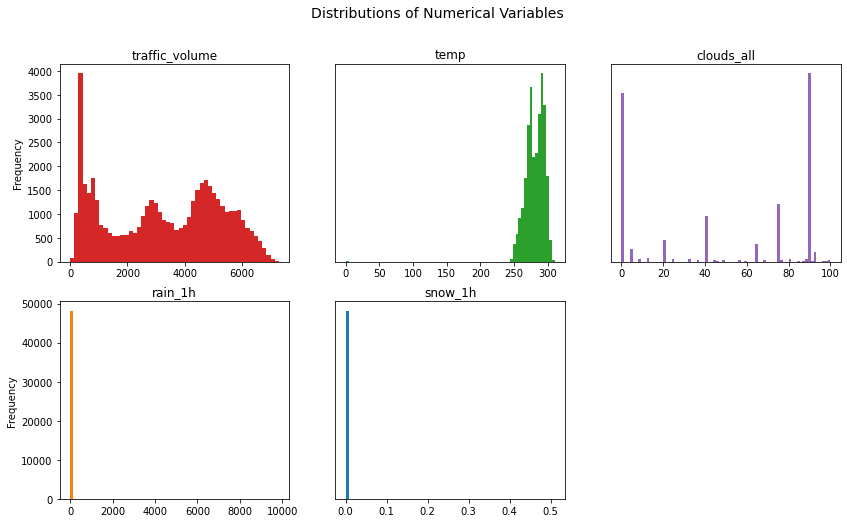

In [3]:
# numeric distributions

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize = (14,8))
plt.suptitle('Distributions of Numerical Variables', fontsize=14)
ax6.axis('off')

df['temp'].plot(ax=ax2, kind='hist', bins=75, color='tab:green').set_title('temp').axes.get_yaxis().set_visible(False)
df['rain_1h'].plot(ax=ax4, kind='hist', bins=75, color='tab:orange').set_title('rain_1h')
df['snow_1h'].plot(ax=ax5, kind='hist', bins=75,color='tab:blue').set_title('snow_1h').axes.get_yaxis().set_visible(False)
df['clouds_all'].plot(ax=ax3, kind='hist', bins=75,color='tab:purple').set_title('clouds_all').axes.get_yaxis().set_visible(False)
df['traffic_volume'].plot(ax=ax1, kind='hist', bins=50,color='tab:red').set_title('traffic_volume')

In [4]:

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (12,12))
# plt.suptitle('Distributions of Categorical Variables', fontsize=14)

# # fig.tight_layout()
# ax4.axis('off')

df['weather_main'].value_counts(ascending=True).plot(ax=ax2, kind='barh', color='tab:blue').set_title('weather_main')
plt.show()
df['weather_description'].value_counts(ascending=True).plot(ax=ax3, kind='barh', color='tab:blue').set_title('weather_description')
df['holiday'].value_counts(ascending=True).plot(ax=ax1, kind='barh', color='tab:blue').set_title('holiday')

Text(0.5, 1.0, 'holiday')

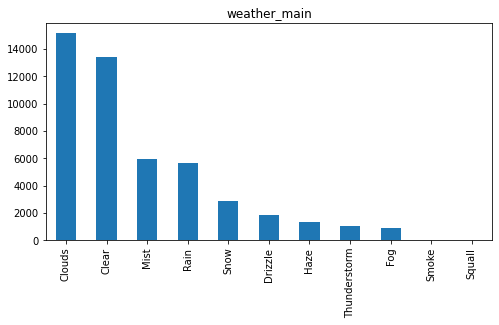

Text(0.5, 1.0, 'holiday')

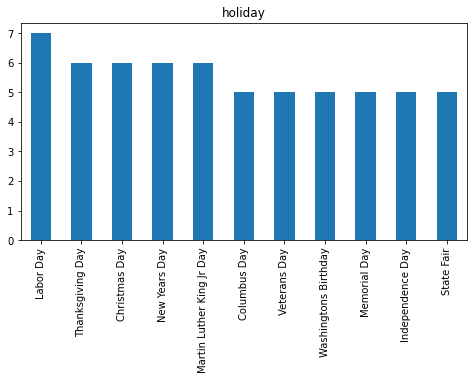

In [5]:
plt.figure(figsize=(8,4))
df['weather_main'].value_counts(ascending=False).plot(kind='bar', color='tab:blue').set_title('weather_main')
plt.show()
plt.figure(figsize=(8,4))

# df['weather_description'].value_counts(ascending=False).plot(kind='bar', color='tab:blue').set_title('weather_description')
# plt.show()
# plt.figure(figsize=(8,4))

holiday_df = df[df['holiday'] != 'None']
holiday_df['holiday'].value_counts(ascending=False).plot(kind='bar', color='tab:blue').set_title('holiday')

In [6]:
to_drop = ['holiday', 'snow_1h', 'weather_description', 'rain_1h']
df.drop(to_drop, axis=1, inplace=True)

cols = ['date_time','traffic_volume', 'weather_main','temp', 'clouds_all']
df=df[cols]
df.head()

,date_time,traffic_volume,weather_main,temp,clouds_all
0,2012-10-02 09:00:00,5545,Clouds,288.28,40
1,2012-10-02 10:00:00,4516,Clouds,289.36,75
2,2012-10-02 11:00:00,4767,Clouds,289.58,90
3,2012-10-02 12:00:00,5026,Clouds,290.13,90
4,2012-10-02 13:00:00,4918,Clouds,291.14,75


In [10]:
df['date_time']= pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index(pd.DatetimeIndex(df['date_time']))
# .drop('date_time', axis=1)
df.dtypes
df.head()

,date_time,traffic_volume,weather_main,temp,clouds_all
date_time,,,,,
2012-10-02 09:00:00,2012-10-02 09:00:00,5545,Clouds,288.28,40
2012-10-02 10:00:00,2012-10-02 10:00:00,4516,Clouds,289.36,75
2012-10-02 11:00:00,2012-10-02 11:00:00,4767,Clouds,289.58,90
2012-10-02 12:00:00,2012-10-02 12:00:00,5026,Clouds,290.13,90
2012-10-02 13:00:00,2012-10-02 13:00:00,4918,Clouds,291.14,75


In [11]:
df.index.min(), df.index.max()

(Timestamp('2012-10-02 09:00:00'), Timestamp('2018-09-30 23:00:00'))

In [12]:
ts = df['2015-09-30':'2018-09-29']
ts

,date_time,traffic_volume,weather_main,temp,clouds_all
date_time,,,,,
2015-09-30 00:00:00,2015-09-30 00:00:00,551,Clear,278.65,1
2015-09-30 02:00:00,2015-09-30 02:00:00,273,Clear,277.54,1
2015-09-30 03:00:00,2015-09-30 03:00:00,348,Clear,277.34,1
2015-09-30 04:00:00,2015-09-30 04:00:00,947,Clear,277.21,1
2015-09-30 05:00:00,2015-09-30 05:00:00,3021,Clear,276.89,1
...,...,...,...,...,...
2018-09-29 19:00:00,2018-09-29 19:00:00,3818,Clouds,280.68,90
2018-09-29 20:00:00,2018-09-29 20:00:00,3338,Clouds,280.55,90
2018-09-29 21:00:00,2018-09-29 21:00:00,2950,Clouds,280.40,90


In [13]:
ts.describe()

,traffic_volume,temp,clouds_all
count,29498.000000,29498.000000,29498.000000
mean,3256.910672,281.976057,48.520306
std,1974.218558,12.128926,39.636124
min,0.000000,243.390000,0.000000
25%,1195.000000,273.150000,1.000000
50%,3413.000000,283.365000,56.000000
75%,4910.000000,291.890000,90.000000
max,7280.000000,310.070000,100.000000


In [11]:
ts.describe(include='object')

,weather_main
count,29498
unique,11
top,Clear
freq,8549


### graphical representation of ts

In [12]:
# parse datetime
ts['weekday'] = ts.date_time.dt.day_name()
ts['hour'] = ts.date_time.dt.hour
ts['month'] = ts.date_time.dt.month
ts['year'] = ts.date_time.dt.year
ts.head()

C:\Users\anali\AppData\Local\Temp/ipykernel_8752/1304811225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['weekday'] = ts.date_time.dt.day_name()
C:\Users\anali\AppData\Local\Temp/ipykernel_8752/1304811225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['hour'] = ts.date_time.dt.hour
C:\Users\anali\AppData\Local\Temp/ipykernel_8752/1304811225.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,date_time,traffic_volume,weather_main,temp,clouds_all,weekday,hour,month,year
date_time,,,,,,,,,
2015-09-30 00:00:00,2015-09-30 00:00:00,551,Clear,278.65,1,Wednesday,0,9,2015
2015-09-30 02:00:00,2015-09-30 02:00:00,273,Clear,277.54,1,Wednesday,2,9,2015
2015-09-30 03:00:00,2015-09-30 03:00:00,348,Clear,277.34,1,Wednesday,3,9,2015
2015-09-30 04:00:00,2015-09-30 04:00:00,947,Clear,277.21,1,Wednesday,4,9,2015
2015-09-30 05:00:00,2015-09-30 05:00:00,3021,Clear,276.89,1,Wednesday,5,9,2015


Text(0.5, 1.0, 'Monthly Volume')

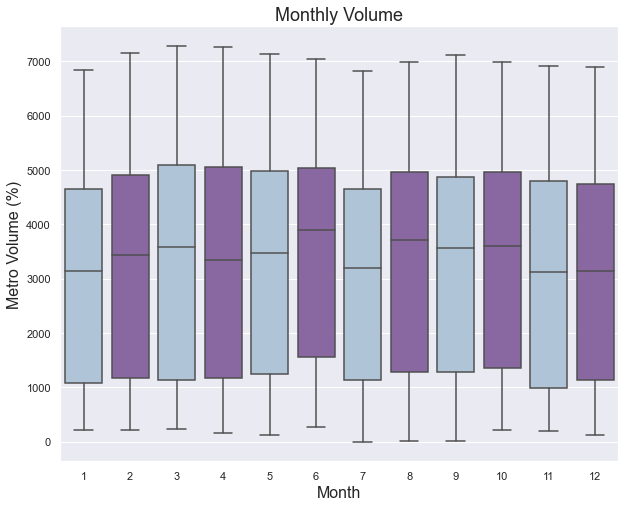

In [13]:
plt.figure(figsize=(10,8))
sns.set_theme(style="darkgrid", palette=None)

fig = sns.boxplot(y='traffic_volume',
            x='month', 
            data = ts, 
            palette=sns.color_palette('BuPu', n_colors=2))
plt.xlabel('Month', fontsize=16) 
plt.ylabel('Metro Volume (%)', fontsize=16) 
plt.title('Monthly Volume', fontsize=18)

Text(0.5, 1.0, 'Daily Volume')

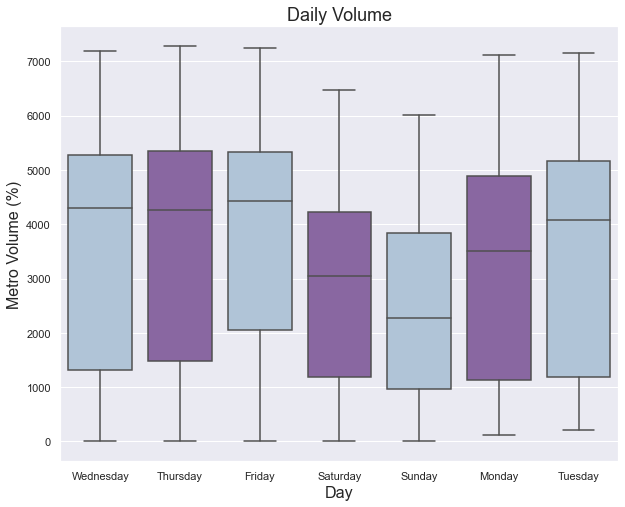

In [14]:
plt.figure(figsize=(10,8))
sns.set_theme(style="darkgrid", palette=None)

fig2 = sns.boxplot(y='traffic_volume',
            x='weekday', 
            data = ts, 
            palette=sns.color_palette('BuPu', n_colors=2))
plt.xlabel('Day', fontsize=16) 
plt.ylabel('Metro Volume (%)', fontsize=16) 
plt.title('Daily Volume', fontsize=18)

Text(0.5, 1.0, 'Hourly Volume')

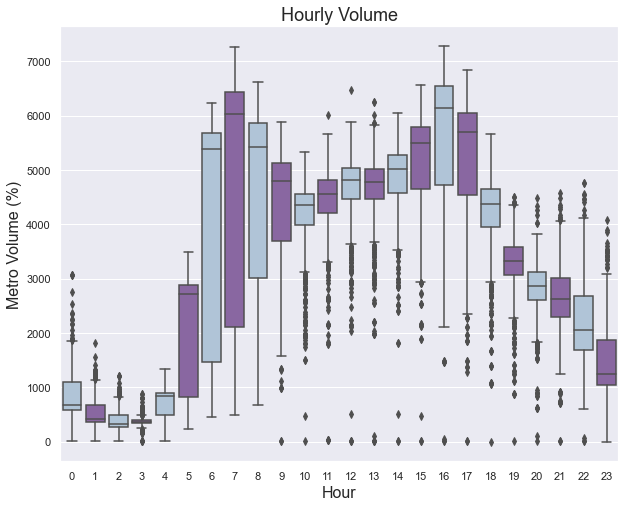

In [15]:
plt.figure(figsize=(10,8))
sns.set_theme(style="darkgrid", palette=None)

fig2 = sns.boxplot(y='traffic_volume',
            x='hour', 
            data = ts, 
            palette=sns.color_palette('BuPu', n_colors=2))
plt.xlabel('Hour', fontsize=16) 
plt.ylabel('Metro Volume (%)', fontsize=16) 
plt.title('Hourly Volume', fontsize=18)

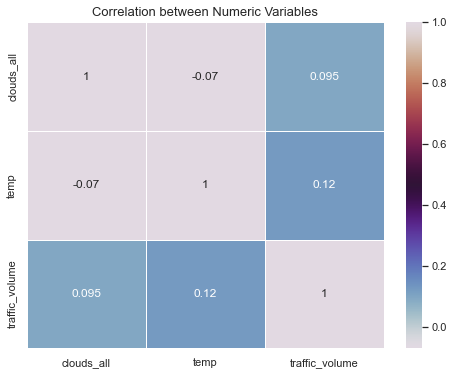

In [16]:
#correlation between different numeric variables. plot shows no strong correlation between traffic and other variables
cm = ts[['clouds_all','temp','traffic_volume']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,linewidths=0.5,cmap='twilight')
plt.title('Correlation between Numeric Variables', fontsize=13)
plt.show()

Text(0, 0.5, 'Traffic Volume')

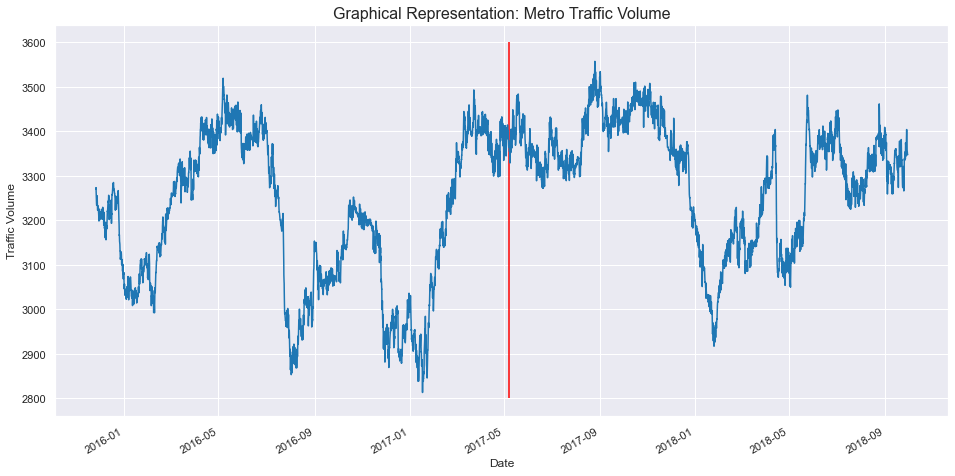

In [61]:
X = ts.traffic_volume.values
split = round(len(X)/2)

ts.sort_index()['traffic_volume'].rolling(1000).mean().plot(figsize = (16,8))
plt.title('Graphical Representation: Metro Traffic Volume', fontsize=16)
plt.vlines(ts.date_time.iloc[split], 2800, 3600, color='red')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')

In [ ]:
plt.hist(np.log(ts.traffic_volume.dropna))

In [ ]:
# check autocorrelation

<Figure size 1440x720 with 0 Axes>

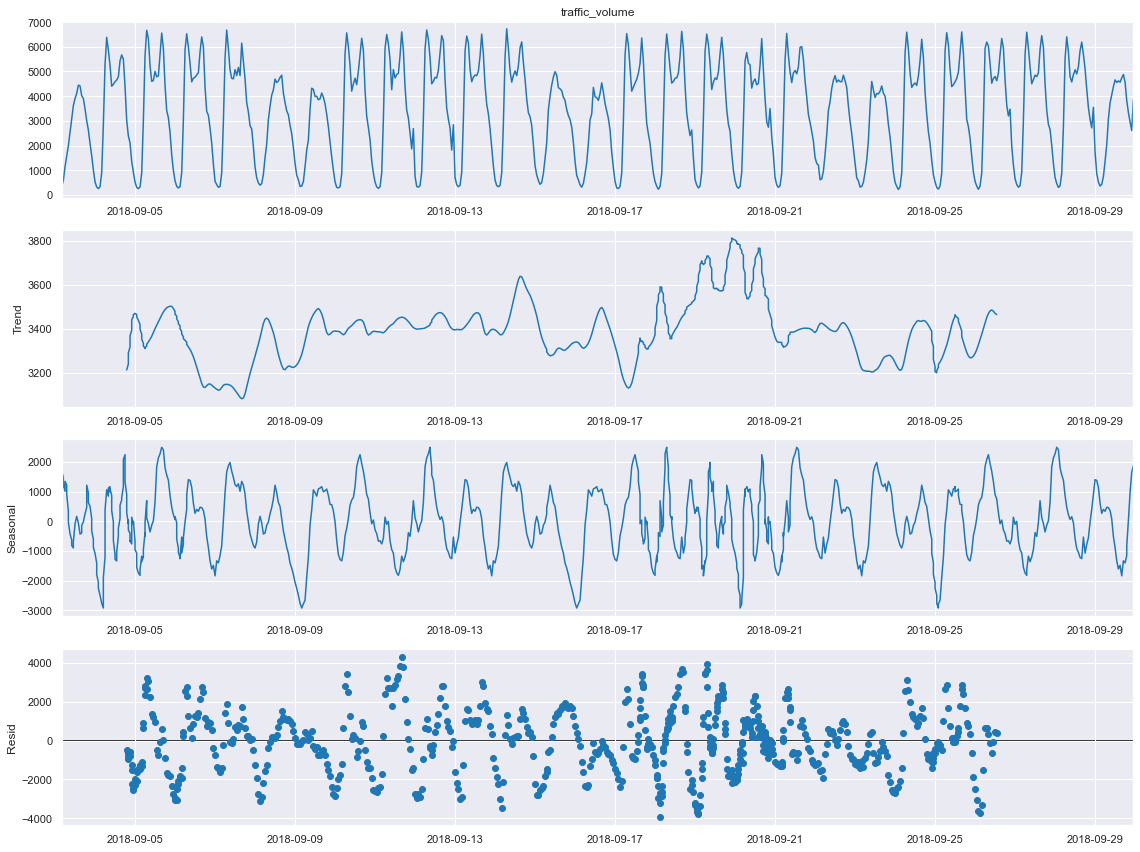

In [83]:
# decomposition


res = seasonal_decompose(ts.traffic_volume[-168*5:], model='additive', period=168)
plt.figure(figsize=(20,10))
# res.plot()
# plt.show()

fig = res.plot()
fig.set_size_inches((16, 12))

# Tight layout to realign things
fig.tight_layout()
plt.show()

In [57]:
# check for stationarity 

X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print('mean1= %f, mean2= %f' %(mean1, mean2))
print('var1= %f, var2= %f' %(var1, var2))

mean1= 3203.011119, mean2= 3310.810224
var1= 3878882.025234, var2= 3910121.223393


In [67]:
# augmented dickey fuller test

result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -20.684533
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [14]:
window = 168
cutoff = 0.05

def test_stationarity(timeseries, window = window, cutoff = cutoff):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='green', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Moving Average: Window Size= %d' % window, fontsize=16)
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 24 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

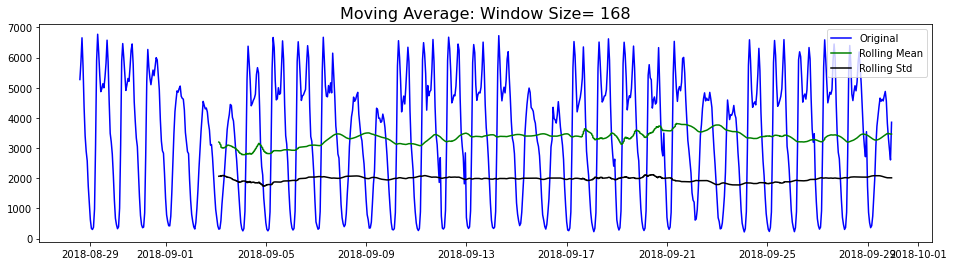

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.660439e+00
p-value                        4.862491e-09
#Lags Used                     2.400000e+01
Number of Observations Used    9.830000e+02
Critical Value (1%)           -3.437020e+00
Critical Value (5%)           -2.864485e+00
Critical Value (10%)          -2.568338e+00
dtype: float64


In [15]:
ts_recent = ts[-168*6:]

test_stationarity(ts_recent.traffic_volume)

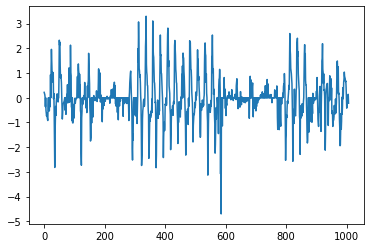

In [27]:
from pandas import Series

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
X = ts_recent.temp.values
diff = difference(X)
diff2 = difference(ts_recent.clouds_all.values)
plt.plot(diff)

In [26]:
diff

0       0.22
1       0.17
2       0.13
3       0.03
4      -0.36
        ... 
1002    0.00
1003   -0.13
1004   -0.15
1005    0.14
1006   -0.22
Length: 1007, dtype: float64

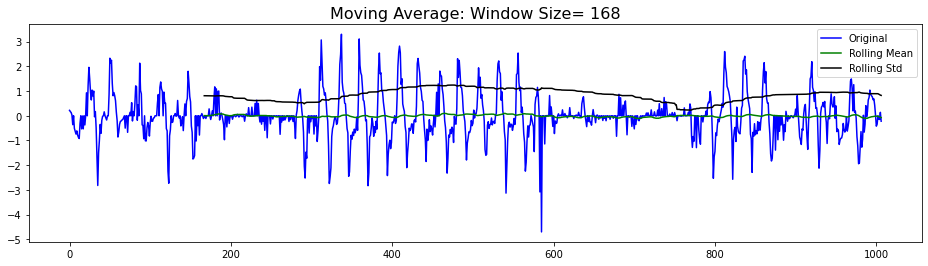

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.499883e+00
p-value                        1.169012e-08
#Lags Used                     2.400000e+01
Number of Observations Used    9.820000e+02
Critical Value (1%)           -3.437027e+00
Critical Value (5%)           -2.864488e+00
Critical Value (10%)          -2.568340e+00
dtype: float64


In [23]:

test_stationarity(diff)

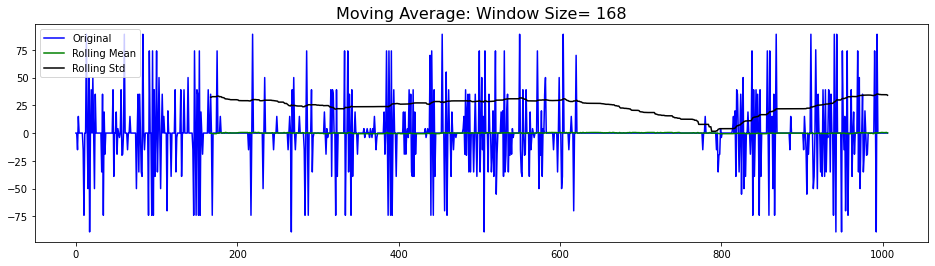

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -8.796495e+00
p-value                        2.169320e-14
#Lags Used                     2.300000e+01
Number of Observations Used    9.830000e+02
Critical Value (1%)           -3.437020e+00
Critical Value (5%)           -2.864485e+00
Critical Value (10%)          -2.568338e+00
dtype: float64


In [28]:
test_stationarity(diff2)

In [104]:
# ACF and PACF plots

lag = 24
lag_pacf = pacf(ts_recent.traffic_volume, nlags=lag, method='ols')
lag_acf = acf(ts_recent.traffic_volume, nlags=lag)

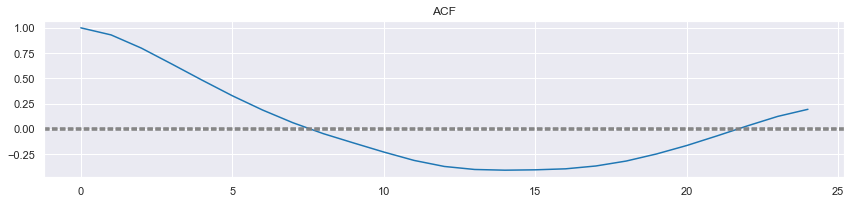

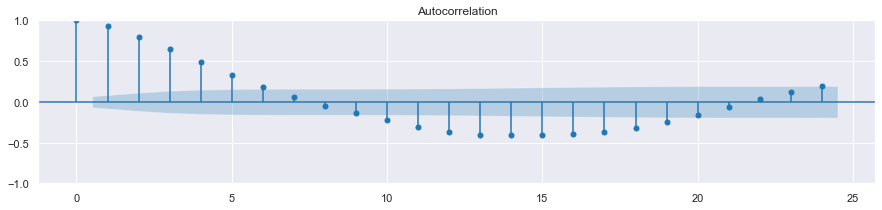

In [105]:
#Plot ACF: 
plt.figure(figsize=(12,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(ts_recent.traffic_volume, ax=plt.gca(),lags=lag)
plt.show()

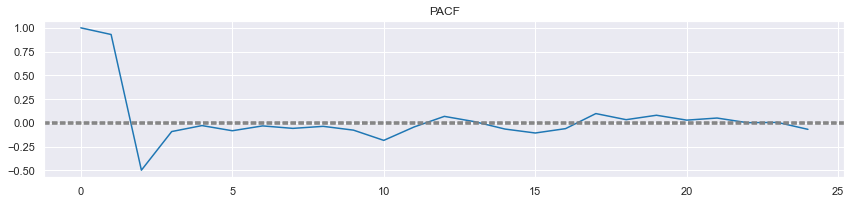

C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


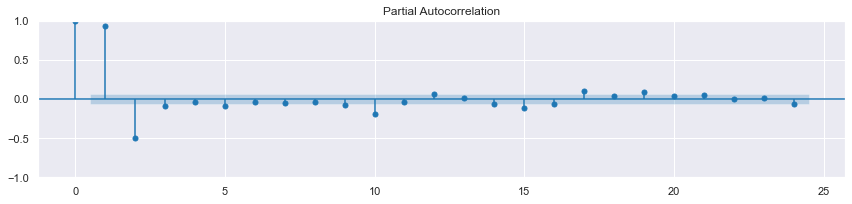

In [106]:
#Plot PACF:
plt.figure(figsize=(12,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
plot_pacf(ts_recent.traffic_volume, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

In [141]:
ts_recent.to_csv("data/ts_recent.csv", index=False)

In [108]:
ts.to_csv("data/ts.csv",index=False)

In [121]:
# check cointegration

vol = ts_recent.traffic_volume
temp = ts_recent.temp
clouds = ts_recent.clouds_all

C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


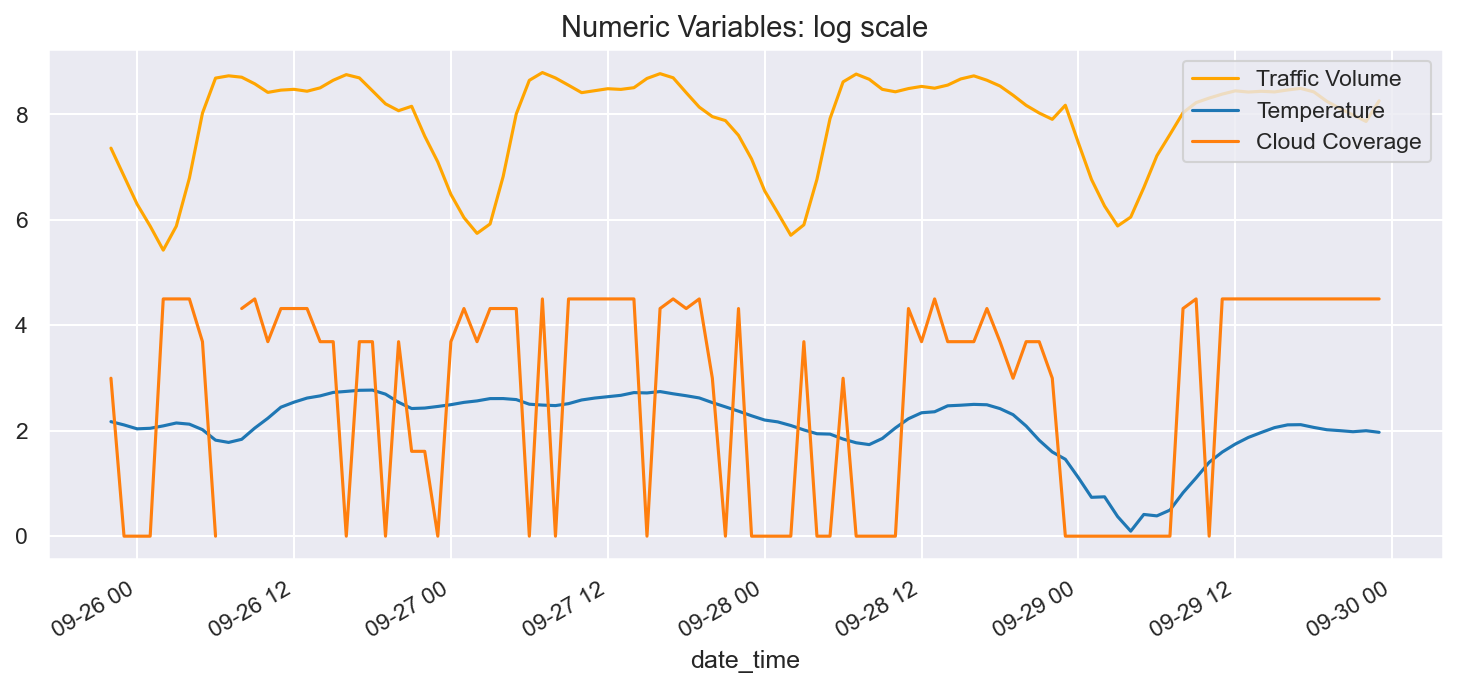

In [144]:
# to set the plot size
plt.figure(figsize=(12, 5), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
np.log(vol[-100:]).plot(label='Traffic Volume', color='orange')
np.log(temp[-100:]-273.15).plot(label='Temperature')
np.log(clouds[-100:]).plot(label='Cloud Coverage')
  
# adding title to the plot
plt.title('Numeric Variables: log scale', fontsize=14)
  
plt.legend(loc=1)